In [1]:
import torch
from torch import nn  
import torchvision
import torchvision.datasets as datasets
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from torch.utils.data import TensorDataset
from torch import optim
from mnist import MnistLoader
from model import VAE, LatentEncoder, AutoEncoder
from train import VAETrainer, vae_loss
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torchvision.transforms as transforms
from utils import get_label
import pandas as pd
from attack import Attack

In [2]:
to_pil_image = transforms.ToPILImage()
def image_to_vid(images, name):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave(f'outputs/{name}.gif', imgs)

In [3]:
data = MnistLoader(batch_size=128, shuffle=True, normalize=False)
vae = VAE(latent_dim=16) 
vae.load_state_dict(torch.load('saved_models/vae_state_dict_v1'))
vae.cuda()

VAE(
  (cnn_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_encoder): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (fc_decoder): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): ReLU()
  )
  (cnn_decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
  )
  (output_decoder): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [4]:
latent_encoder = LatentEncoder()
latent_encoder.cuda()

autoencoder = AutoEncoder(vae, latent_encoder)
autoencoder.cuda()
autoencoder.load_state_dict(
    torch.load('saved_models/vae_lcifr_trained')
    )

<All keys matched successfully>

In [11]:
clf = LatentEncoder()
clf.cuda()
clf.load_state_dict(torch.load('saved_models/latent_state_dict_v1'))

<All keys matched successfully>

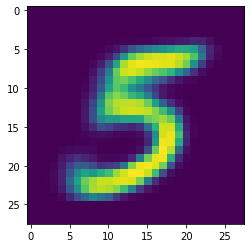

In [8]:
vae.eval()
x_train = data.get_data('x_train').cuda()
z, _, _ = vae.encoder_forward(x_train[0:1])
im = vae.decoder_forward(z).detach().cpu()
im_to_show = im.numpy()[0,0]
plt.imshow(im_to_show)
plt.show()

In [29]:
for j in range(16):
    a = np.linspace(-.5, .5, 50)
    zp = z.detach().clone()
    images = []
    for i in range(50):
        zp[0, j] = a[i]
        im = vae.decoder_forward(zp).detach()[0, 0]
        images.append(im)
    image_to_vid(images, f'comp{j}')

In [15]:
features, _ = clf.forward(im.cuda())
a = np.linspace(-.5, .5, 50)
zp = z.detach().clone()
dist = []
for i in range(50):
    zp[0, 5] = a[i]
    img = vae.decoder_forward(zp)
    new_features, _ = clf.forward(img.cuda())
    dist.append(torch.sum((new_features - features)**2))

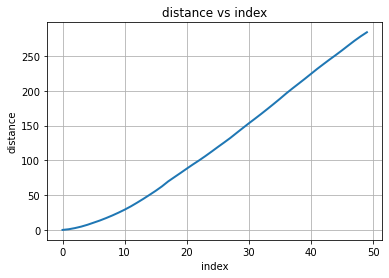

In [16]:
plt.plot(dist, linewidth=2)
plt.grid(True,  which='both')
plt.xlabel('index')
plt.ylabel('distance')
plt.title('distance vs index')
plt.savefig('outputs/dist.pdf')

In [17]:
features = autoencoder.encode(z)
a = np.linspace(-.5, .5, 50)
zp = z.detach().clone()
dist = []
for i in range(50):
    zp[0, 5] = a[i]
    new_features = autoencoder.encode(zp)
    dist.append(torch.sum((new_features - features)**2))

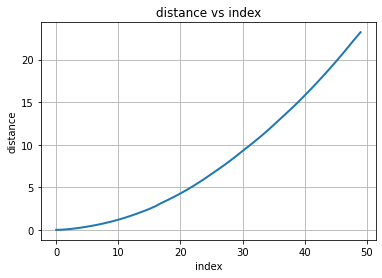

In [18]:
plt.plot(dist, linewidth=2)
plt.grid(True,  which='both')
plt.xlabel('index')
plt.ylabel('distance')
plt.title('distance vs index')
plt.savefig('outputs/dist.pdf')

In [78]:
predictions

[tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor([5], device='cuda:0'),
 tensor(

In [72]:
model = concat(vae, clf)
attack = Attack(model=model,
                loss_fn=nn.MSELoss(reduction='sum'),
                device='cuda',
                eps=0.5)

adv = attack.pgd_attack(alpha=0.4, 
                        input_vec=z, 
                        targets=features.detach(), 
                        iterations=20, 
                        num_restarts=1, 
                        random_start=True)
# adv =  attack.fgsm_attack(z.detach(),  features.detach())

In [86]:
torch.sum((adv - z)**2)

tensor(3.8400, device='cuda:0', grad_fn=<SumBackward0>)

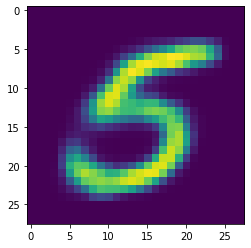

In [74]:
im = vae.decoder_forward(adv).detach()[0,0]
im = im.cpu().numpy()
plt.imshow(im)

In [2]:
data = MnistLoader(batch_size=128, shuffle=True, normalize=False)
train, val = data.train_val_split(0.8)

ValueError: Sum of input lengths does not equal the length of the input dataset!

94